Accordion(children=(VBox(children=(IntText(value=100, description='Number of computer participants:', style=De…

ToggleButtons(options=('Start', 'Pause', 'Resume', 'End'), value=None)

AppLayout(children=(HTML(value='', layout=Layout(grid_area='header')), GridspecLayout(children=(HTML(value='',…

Simulation is beginning
Simulation started.
Current IB market state is None, with -0.06319212913513184 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is None, with -0.07325053215026855 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is None, with -1.1328153610229492 seconds remaining.
                    Timestamp Trader_ID Quantity Price
0  2024-07-10 00:25:23.203065        32      211   8.0
1  2024-07-10 00:25:23.309294         0      222   8.0
2  2024-07-10 00:25:23.718217        37      156   8.0
3  2024-07-10 00:25:23.019602        57      261  7.99
4  2024-07-10 00:25:23.044961        62       96  7.99
5  2024-07-10 00:25:23.124139        54      336  7.99
6  2024-07-10 00:25:23.241231        21      104  7.99
7  2024-07-10 00:25:23.408825        10      262  7.99
8  2024-07-10 00:25:23.446473        49      132  7.99
9  2024-07-10 00:25:23.

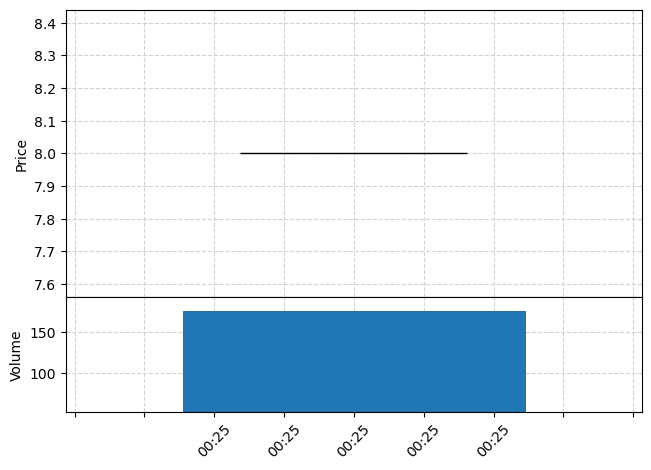

Simulaiton resumed.
Current IB market state is bear, with 7.973662376403809 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is bear, with 7.915440559387207 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is bear, with 7.872303247451782 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is bear, with 7.85923433303833 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is bear, with 7.815045595169067 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is bear, with 7.777141332626343 seconds remaining.
Empty DataFrame
Columns: [Timestamp, Trader_ID, Quantity, Price]
Index: []
Current IB market state is bear, with 7.756657838821411 seconds remaining.
Empty 

In [1]:
# import libraries
import random
import time
import threading
import os
import mplfinance as mpf
import pandas as pd
import numpy as np
import datetime as dt
import ipywidgets as widgets
from prettytable import PrettyTable
from ipywidgets import AppLayout
from IPython.display import display

# import local scripts
import botlogic as bl
import botorder as bo
import participantsetup as ps

# Creating a "comms" folder which is used as a dependency of this code in order to create/update visualisations
folder_path = 'comms'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

output_path = 'output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Market infrastructure
def buy_orderbook_append (timestamp, trader_id, quantity, price): 
    global buy_orderbook
    if timestamp == None or trader_id == None:
        print("Empty buy ammend")
        raise ValueError
    else:
        new_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : trader_id, "Quantity" : quantity, "Price" : price})
        buy_orderbook = pd.concat([buy_orderbook, new_order.to_frame().T], ignore_index=True)
        buy_orderbook.sort_values(by=["Price", "Timestamp"], ascending=[False, True], inplace=True)
        h_buy_orderbook_append(new_order, "open_order", None, None)

def sell_orderbook_append (timestamp, trader_id, quantity, price):
    global sell_orderbook 
    if timestamp == None or trader_id == None:
        print("Empty sell ammend")
        raise ValueError
    else:
        new_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : trader_id, "Quantity" : quantity, "Price" : price})
        sell_orderbook = pd.concat([sell_orderbook, new_order.to_frame().T], ignore_index=True)
        sell_orderbook.sort_values(by=["Price", "Timestamp"], ascending=[True, True], inplace=True)
        h_sell_orderbook_append(new_order, "open_order", None, None)

def transaction_append (timestamp, buy_id, sell_id, quantity, price, aggressor_id):
    global transaction_log
    transaction = pd.Series({"Timestamp" : timestamp, "Buy_Side_Trader_ID" : buy_id, "Sell_Side_Trader_ID" : sell_id, "Quantity" : quantity, "Price" : price, "Aggressor_ID" : aggressor_id})
    transaction_log = pd.concat([transaction_log, transaction.to_frame().T], ignore_index=True)
    transaction_log["Timestamp"] = pd.to_datetime(transaction_log["Timestamp"])
    transaction_log.sort_values(by=["Timestamp"], ascending=[True], inplace=True)

def h_buy_orderbook_append (input, action, action_time, aggressor):
    global historic_buy_orderbook
    if action == 'open_order':
        historic_buy_orderbook = pd.concat([historic_buy_orderbook, input.to_frame().T], ignore_index=True)
        historic_buy_orderbook.sort_values(by=["Timestamp"], ascending=[True], inplace=True)
    elif action == 'order_executed':
        match_cols = ["Timestamp", "Trader_ID", "Quantity", "Price"]
        update_cols = ["Action", "Action_Timestamp", "Aggressor"]
        for index, row in historic_buy_orderbook.iterrows():
            match_count = sum(row[match_cols] == pd.Series(input, index=match_cols))
            if match_count == 4:
                historic_buy_orderbook.loc[index, update_cols] = ["Executed", action_time, aggressor]
    elif action == 'order_cancelled':
        match_cols = ["Timestamp", "Trader_ID", "Quantity", "Price"]
        update_cols = ["Action", "Action_Timestamp", "Aggressor"]
        for index, row in historic_buy_orderbook.iterrows():
            match_count = sum(row[match_cols] == pd.Series(input, index=match_cols))
            if match_count == 4:
                historic_buy_orderbook.loc[index, update_cols] = ["Cancelled", action_time, aggressor]

def h_sell_orderbook_append (input, action, action_time, aggressor):
    global historic_sell_orderbook
    if action == 'open_order':
        historic_sell_orderbook = pd.concat([historic_sell_orderbook, input.to_frame().T], ignore_index=True)
        historic_sell_orderbook.sort_values(by=["Timestamp"], ascending=[True], inplace=True)
    elif action == 'order_executed':
        match_cols = ["Timestamp", "Trader_ID", "Quantity", "Price"]
        update_cols = ["Action", "Action_Timestamp", "Aggressor"]
        for index, row in historic_sell_orderbook.iterrows():
            match_count = sum(row[match_cols] == pd.Series(input, index=match_cols))
            if match_count == 4:
                historic_sell_orderbook.loc[index, update_cols] = ["Executed", action_time, aggressor]
    elif action == 'order_cancelled':
        match_cols = ["Timestamp", "Trader_ID", "Quantity", "Price"]
        update_cols = ["Action", "Action_Timestamp", "Aggressor"]
        for index, row in historic_sell_orderbook.iterrows():
            match_count = sum(row[match_cols] == pd.Series(input, index=match_cols))
            if match_count == 4:
                historic_sell_orderbook.loc[index, update_cols] = ["Cancelled", action_time, aggressor]

def h_orderbook_amend (input, q_update, q_original, side):
    global historic_buy_orderbook, historic_sell_orderbook
    match_cols = ["Timestamp", "Trader_ID", "Quantity", "Price"]
    new_cols = ["Amended", "Old Quantity", "Amended_Timestamp"]
    amended_time = dt.datetime.now()
    if side == "buy":
        for index, row in historic_buy_orderbook.iterrows():
            match_count = sum(row[match_cols] == input)
            if match_count == 4:
                historic_buy_orderbook.loc[index, "Quantity"] = q_update
                historic_buy_orderbook.loc[index, new_cols] = [True, q_original, amended_time]
    elif side == "sell":
        for index, row in historic_sell_orderbook.iterrows():
            match_count = sum(row[match_cols] == input)
            if match_count == 4:
                historic_sell_orderbook.loc[index, "Quantity"] = q_update
                historic_sell_orderbook.loc[index, new_cols] = [True, q_original, amended_time]

# Pulling key figures
class market_key_figures:
    def __init__(self):
        global transaction_log, buy_orderbook, sell_orderbook
        # tests to calculate figs from transaction log
        try:
            transaction_log.sort_values(by=["Timestamp"], ascending=[True], inplace=True)
            self.market_price = transaction_log["Price"].iloc[-1]
            self.open_price = transaction_log["Price"].iloc[0]
            self.abs_price_mvmt = round(self.market_price - self.open_price,2)
            self.per_price_mvmt = round((self.abs_price_mvmt/self.open_price)*100,2)

            transaction_log.sort_values(by=["Price"], ascending=[True], inplace = True)
            self.price_max = transaction_log["Price"].iloc[-1]
            self.price_min = transaction_log["Price"].iloc[0]
            self.price_range = round(self.price_max - self.price_min,2)

            transaction_log.sort_values(by=["Timestamp"], ascending=[True], inplace=True)
            self.transact_test = "pass"
        except:
            self.transact_test = "fail"

        # tests to calculate figs from orderbook
        try: 
            buy_orderbook.sort_values(by=["Price", "Timestamp"], ascending=[False, True], inplace=True)
            self.best_bid = buy_orderbook['Price'].iloc[0]
            self.buy_orderbook_test = "b_pass"
        except:
            self.buy_orderbook_test = "b_fail"

        try:
            sell_orderbook.sort_values(by=["Price", "Timestamp"], ascending=[True, True], inplace=True)
            self.best_ask = sell_orderbook['Price'].iloc[0]
            self.sell_orderbook_test = "s_pass"
        except:
            self.sell_orderbook_test = "s_fail"
      
        # combining these tests to produce a single outcome result 
        if self.transact_test == "pass" and (self.buy_orderbook_test == "b_pass" and self.sell_orderbook_test == "s_pass"):
            self.key_figs_test = "pass"
        elif self.transact_test == "fail" and (self.buy_orderbook_test == "b_pass" and self.sell_orderbook_test == "s_pass"):
            self.key_figs_test = "o_semipass"
        elif self.transact_test == "pass" and (self.buy_orderbook_test == "b_fail" or self.sell_orderbook_test == "s_fail"):
            self.key_figs_test = "t_semipass"

        #elif self.transact_test == "fail" and (self.buy_orderbook_test == "b_fail" or self.sell_orderbook_test == "s_fail"):
        else: 
            self.key_figs_test = "fail"

# Order Matching & transaction log
def orderbook_matching (input_order, bot):
    global df_participants, transaction_log, buy_orderbook, sell_orderbook
    key_figs =market_key_figures()
    order_price = round(input_order["Price"],2)
    bid_ask_flag = input_order["Flag"]
    order_quantity = int(input_order["Quantity"])
    input_order_id = input_order["Trader_ID"]
    timestamp = dt.datetime.now()

    def bot_crediting (transaction_price, transaction_qty, buy_ID, sell_ID, price_diff, aggressor, bot):
        global df_participants
        transaction_val = transaction_price * transaction_qty
        if aggressor == "buy":
            # crediting aggressor to the bot profile
            bot[1] += transaction_qty   
            # crediting profile to the sell participant
            df_participants.loc[df_participants["Trader_ID"] == sell_ID, "Wealth"] += transaction_val  
        elif aggressor == "sell":
            # crediting profile to the bot profile
            df_participants.loc[df_participants["Trader_ID"] == buy_ID, "Asset"] += transaction_qty
            # crediting aggressor to the sell participant
            bot[2] += transaction_val    
        if price_diff > 0 and aggressor == "buy":
            val_diff = price_diff * transaction_qty
            bot[2] += val_diff
        return bot

    # Not the cleanest code, but it works for now. 
    def bid_price_check (order_price, best_ask):
        if order_price >= best_ask:
            check = "True"
        else:
            check = "False"
        return check
    def ask_price_check (order_price, best_bid):
        if order_price <= best_bid:
            check = "True"
        else:
            check = "False"
        return check
    
    try:
        bprice_check = bid_price_check(order_price, key_figs.best_ask)
    except:
        bprice_check = "False"
    
    try:
        aprice_check = ask_price_check(order_price, key_figs.best_bid)
    except:
        aprice_check = "False"

    if bid_ask_flag == "bid" and order_price >= key_figs.best_ask:
        # Pulling sell orderbook info
        best_sell_id = sell_orderbook['Trader_ID'].iloc[0]
        best_sell_qty = sell_orderbook['Quantity'].iloc[0]
        price_diff = order_price - key_figs.best_ask

        # Running a while loop to execute the order against as many eligible orders 
        while order_quantity > 0 and (key_figs.sell_orderbook_test =="s_pass" and bprice_check == "True"):
            result = order_quantity - best_sell_qty

            if result >= 0:
                # this will clear the sell order as it can be executed against in its full entirety 
                transaction_append(timestamp, input_order_id, best_sell_id, best_sell_qty, key_figs.best_ask, input_order_id)

                # removing cleared sell order from orderbook, and resets index
                cleared_order = sell_orderbook.iloc[0]
                h_sell_orderbook_append(cleared_order, "order_executed", timestamp, False)
                sell_orderbook = sell_orderbook.iloc[1:]
                sell_orderbook.reset_index(drop = True, inplace=True)
                order_quantity = result
                bot = bot_crediting(key_figs.best_ask, best_sell_qty, input_order_id, best_sell_id, price_diff, "buy", bot)

            elif result < 0:
                # this clears the bid order against the sell order with left over quantity, writing the new quantity to the sell orderbook 
                transaction_append(timestamp, input_order_id, best_sell_id, order_quantity, key_figs.best_ask, input_order_id)
                bot = bot_crediting(key_figs.best_ask, order_quantity, input_order_id, best_sell_id, price_diff, "buy", bot)
                h_buy_orderbook_append(input_order, "order_executed", timestamp, True)

                # updating the quantity of the partially-filled sell order
                new_sell_qty = best_sell_qty - order_quantity
                amended_order = sell_orderbook.iloc[0]
                h_orderbook_amend(amended_order, new_sell_qty, best_sell_qty, "sell")
                sell_orderbook.loc[0,"Quantity"] = new_sell_qty 
                order_quantity = 0
            try: 
                key_figs.best_ask = sell_orderbook['Price'].iloc[0]
                best_sell_id = sell_orderbook['Trader_ID'].iloc[0]
                best_sell_qty = sell_orderbook['Quantity'].iloc[0]
                bprice_check = bid_price_check(order_price, key_figs.best_ask)   
            except:    
                if order_quantity > 0: # leftover quantity is written to the order book
                    buy_orderbook_append(timestamp, input_order_id, order_quantity, order_price)
                break


    elif bid_ask_flag == "ask" and order_price <= key_figs.best_bid:   
        # Pulling buy orderbook info
        best_buy_id = buy_orderbook['Trader_ID'].iloc[0]
        best_buy_qty = buy_orderbook['Quantity'].iloc[0]
        price_diff = key_figs.best_bid - order_price

        # Running a while loop to execute the order against as many eligible orders 
        while order_quantity > 0 and (key_figs.buy_orderbook_test == "b_pass" and aprice_check == "True"):
            result = order_quantity - best_buy_qty

            if result >= 0:
                # this will clear the buy order as it can be executed against in its full entirety 
                transaction_append(timestamp, best_buy_id, input_order_id, best_buy_qty, key_figs.best_bid, input_order_id)
    
                # removing cleared buy order from orderbook, and resets index
                cleared_order = buy_orderbook.iloc[0]
                h_buy_orderbook_append(cleared_order, "order_executed", timestamp, False)
                buy_orderbook = buy_orderbook.iloc[1:]
                buy_orderbook.reset_index(drop = True, inplace=True)
                order_quantity = result
                bot = bot_crediting(key_figs.best_bid, best_buy_qty, best_buy_id, input_order_id, price_diff, "sell", bot)  

            elif result < 0:
                # this clears the ask order against the buy order with left over quantity, writing the new quantity to the buy orderbook 
                transaction_append(timestamp, best_buy_id, input_order_id, order_quantity, key_figs.best_bid, input_order_id)
                bot = bot_crediting(key_figs.best_bid, order_quantity, best_buy_id, input_order_id, price_diff, "sell", bot)
                h_sell_orderbook_append(input_order, "order_executed", timestamp, True)

                # updating the quantity of the partially-filled buy order
                new_buy_qty = best_buy_qty - order_quantity
                amended_order = buy_orderbook.iloc[0]
                h_orderbook_amend(amended_order, new_buy_qty, best_buy_qty, "buy")
                buy_orderbook.loc[0,"Quantity"] = new_buy_qty
                order_quantity = 0
            try:
                # updating best bid info
                key_figs.best_bid = buy_orderbook['Price'].iloc[0]
                best_buy_id = buy_orderbook['Trader_ID'].iloc[0]
                best_buy_qty = buy_orderbook['Quantity'].iloc[0]
                aprice_check = ask_price_check(order_price, key_figs.best_bid)
            except:
                if order_quantity > 0: # leftover quantity is written to the order book
                    sell_orderbook_append(timestamp, input_order_id, order_quantity, order_price)   
                break

    # running the price checks again, to see if the order can match against anything else
    try:
        bprice_check = bid_price_check(order_price, key_figs.best_ask)
    except:
        bprice_check = "False"
    try:
        aprice_check = ask_price_check(order_price, key_figs.best_bid)
    except:
        aprice_check = "False"

    # any orders that do not match the best bid are appended to the sell orderbook
    if (bid_ask_flag == "ask" and aprice_check == "False") and order_quantity > 0:
        sell_orderbook_append(timestamp, input_order_id, order_quantity, order_price)
        # any orders that do not match the best ask are appended to the buy orderbook
    elif (bid_ask_flag == "bid" and bprice_check == "False") and order_quantity > 0:
        buy_orderbook_append(timestamp, input_order_id, order_quantity, order_price)
    return bot

def orderbook_vis (orderbook, side, html_flag):
    agg_orderbook = pd.DataFrame(columns=["Price", "Quantity"])
    agg_orderbook = orderbook.groupby("Price").agg({"Quantity" : 'sum'}).reset_index()
    agg_orderbook.columns = ['Price', 'Total_Quantity']
    
    if html_flag == True:
        vis = PrettyTable()
        vis.field_names = ['Price', 'Total_Quantity']
        if side == "b":
            agg_orderbook.sort_values(by=['Price'], ascending=False, inplace=True) 
        for index, row in agg_orderbook.iterrows():
            vis.add_row([row['Price'], row['Total_Quantity']])
        vis = vis.get_html_string()
    elif html_flag == False:
        vis = PrettyTable()
        vis.field_names = ['Price', 'Total_Quantity']
        for index, row in agg_orderbook.iterrows():
            vis.add_row([row['Price'], row['Total_Quantity']])
    return vis

# T.1.1: cancelling orders away from priority
def cancel_faraway_orders (bot):
    global transaction_log, buy_orderbook, sell_orderbook
    key_figs = market_key_figures()
    if key_figs.key_figs_test == 'pass':
        if len(transaction_log) > 24:
            prev_price = transaction_log.iat[-25,4]
        else:
            prev_price = transaction_log.iat[-1,4]
        market_delta = prev_price - key_figs.market_price

        # checking for any orders that should be cancelled. If they are to be cancelled, the appropriate wealth/asset is credited back to the bot's account.    
        for index, order in buy_orderbook.iterrows():
            market_order_spread = key_figs.best_bid - order["Price"]
            if bot[0] == order["Trader_ID"] and market_order_spread > 0.1: # 10 ticks away from priority
                bot["Wealth"] += order["Price"] * order["Quantity"]
                h_buy_orderbook_append (order, 'order_cancelled',dt.datetime.now(),False)
                buy_orderbook.drop(index=index, inplace=True)
            elif bot[0] == order["Trader_ID"] and (market_order_spread <= 0.01 and market_delta > 0.02):           
                bot["Wealth"] += order["Price"] * order["Quantity"]
                h_buy_orderbook_append (order, 'order_cancelled',dt.datetime.now(),False)
                buy_orderbook.drop(index=index, inplace=True)
                
        for index, order in sell_orderbook.iterrows():
            order_market_spread = order["Price"] - key_figs.best_ask
            if bot[0] == order["Trader_ID"] and order_market_spread > 0.1:
                bot["Asset"] += order["Quantity"]
                h_sell_orderbook_append (order, 'order_cancelled',dt.datetime.now(),False)
                sell_orderbook.drop(index=index, inplace=True)
            elif bot[0] == order["Trader_ID"] and (market_order_spread <= 0.01 and market_delta < -0.02):           
                bot["Asset"] += order["Quantity"]
                h_sell_orderbook_append (order, 'order_cancelled',dt.datetime.now(),False)
                sell_orderbook.drop(index=index, inplace=True)
    return bot

# debiting function - takes order info, and debits the money or asset accordinlgy, from the bot
def bot_debiting(bot, input_orders):
    for index, order in input_orders.iterrows():
        qty = int(order["Quantity"])
        price = round(order["Price"],2)
        if order["Flag"] == "bid":
            order_value = price * qty
            bot[2] -= order_value # wealth
        elif order["Flag"] == "ask":    
            bot[1] -= qty # assets
    return bot

def quantity_cap_check(qty):
    if qty > 1000:
        r_qty = 1000
    else:
        r_qty = qty
    return r_qty

# this function is to be called during the initial market startup i.e. key_figs_test = 'fail'. This does not run the matching logic, but rather fills the orderbook instead.
def bot_market_interact_initial (result, bot):
    global buy_orderbook, sell_orderbook
    key_figs = market_key_figures()
    timestamp = dt.datetime.now()
    start_price = 8
    trader_id = bot["Trader_ID"]
    price_offest = round(abs(np.random.standard_normal()) * 4) * 0.01 
    max_buy_quantity = quantity_cap_check(bot["Wealth"] / start_price)
    max_sell_quantity = quantity_cap_check(bot["Asset"])
    df_input_orders = pd.DataFrame(columns=["Timestamp", "Trader_ID", "Quantity", "Price", "Flag"])

    if result == 'buy_order' or result == "buy_execute":
        order_price = round(start_price - price_offest,2)
        order_quantity = round(random.uniform(0.25, 0.45) * max_buy_quantity)
        order_val_check = order_price * order_quantity

        if order_val_check < bot["Wealth"]:
            input_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : trader_id, "Quantity" : order_quantity, "Price" : order_price, "Flag" : "bid"})
            df_input_orders = pd.concat([df_input_orders, input_order.to_frame().T], ignore_index=True)
            bot = bot_debiting(bot, df_input_orders)
            # This is a check to see if the orderbook_matching logic can be initaited i.e. if there are orders on both sides of the market
            if key_figs.key_figs_test == "o_semipass":
                bot = orderbook_matching(input_order, bot)
            else:
                buy_orderbook_append(timestamp, trader_id, order_quantity, order_price)
        
    elif result == 'sell_order' or result == "sell_execute":
        order_price = round(start_price + price_offest, 2)
        order_quantity = round(random.uniform(0.15, 0.35) * max_sell_quantity)
        
        if order_quantity < bot["Asset"]:      
            input_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : trader_id, "Quantity" : order_quantity, "Price" : order_price, "Flag" : "ask"})     
            df_input_orders = pd.concat([df_input_orders, input_order.to_frame().T], ignore_index=True)
            bot = bot_debiting(bot, df_input_orders)          
            # This is a check to see if the orderbook_matching logic can be initaited i.e. if there are orders on both sides of the market
            if key_figs.key_figs_test == "o_semipass":
                bot = orderbook_matching(input_order, bot)  
            else:
                sell_orderbook_append(timestamp, trader_id, order_quantity, order_price)
    return bot

# Writing results to excel file
def file_write(file_name): 
    global df_participants, transaction_log, buy_orderbook, sell_orderbook, historic_buy_orderbook, historic_sell_orderbook
    final_output_path = os.path.join(output_path, file_name)
    df_participants.to_excel(final_output_path)
    with pd.ExcelWriter(final_output_path) as writer:
        df_participants.to_excel(writer, sheet_name='Participants')
        transaction_log.to_excel(writer,sheet_name='Transaction_Log')
        buy_orderbook.to_excel(writer, sheet_name='Buy_Orderbook')
        sell_orderbook.to_excel(writer, sheet_name='Sell_Orderbook')
        historic_buy_orderbook.to_excel(writer,sheet_name='Historic_Buy_Orderbook')
        historic_sell_orderbook.to_excel(writer, sheet_name='Historic_Sell_Orderbook')
#####################################################################
############ End of Market Functions ################################
#####################################################################
############ Beginning of Widget Setup ##############################
#####################################################################
simulation_state = "none"
simulation_thread = None
# Creating widgets for the front end
simulation_button = widgets.ToggleButtons(
    options=["Start", "Pause", "Resume", "End"],
    disabled=False,
    value=None
)
bot_num_widget = widgets.IntText(
    value=100,
    description='Number of computer participants:',
    disabled=False,
    style={'description_width': 'initial'}
)
timer_input = widgets.Checkbox(
    value=False,
    description='Select to specify simulation run time.',
    disabled=False,
    indent=False
)
sim_time_widget = widgets.IntText(
    value=180,
    description='Simulation run time (seconds):',
    disabled=True,
    style={'description_width': 'initial'}
)
file_input = widgets.Checkbox(
    value=False,
    description='Select for output of results to file.',
    disabled=False,
    indent=False
)
file_name_input = widgets.Text(
    value="",
    desciprion='Enter file name (saved to comms folder) e.g. Output.xlsx:',
    disabled=True,
    style={'description_width': 'initial'}
)
def timer_check_change(change):
    sim_time_widget.disabled = not change['new']
timer_input.observe(timer_check_change, names='value')
def file_check_change(change):
    file_name_input.disabled = not change['new']
file_input.observe(file_check_change, names='value')

grouped_widgets = [widgets.VBox([bot_num_widget, timer_input, sim_time_widget, file_input, file_name_input])]
sim_setup = widgets.Accordion(
    children=(grouped_widgets),
    titles=(['Simulation Setup'])
)

market_widget = widgets.HTML()
b_orderbook_widget = widgets.HTML()
s_orderbook_widget = widgets.HTML()
chart_widget = widgets.Image()
user_grid = widgets.GridspecLayout(3,5)
user_profile_widget = widgets.HTML()
user_positions_grid = widgets.GridspecLayout(4,3)
quantity_grid = widgets.GridspecLayout(2,1)
user_cancel_grid = widgets.GridspecLayout(1,2)

# Creating widgets to cancel user orders 
user_cancel_header_html = widgets.HTML(
    value = """
    <html>
        <body>
            <br>
            <i align="center">
                Enter Order ID to cancel:
            </i>
        </body>
    </html>
    """
)
user_cancel = widgets.IntText(
    value=1,
    layout=widgets.Layout(width='50px', height='50px')
)
user_cancel_b = widgets.Button(
    description='Cancel Order',
    button_style='danger'
)
user_cancel_select = widgets.Dropdown(
    options=['Buy', 'Sell'],
    disabled = False,
    layout=widgets.Layout(width='100px', height='50px')
)
user_cancel_html = widgets.HTML()

# Widgets to display user orders
user_borderbook_html = widgets.HTML()
user_sorderbook_html = widgets.HTML()
user_buy_orders_widget = widgets.HTML()
user_sell_orders_widget = widgets.HTML()

# Define widgets for user interaction
order_side_widget = widgets.ToggleButtons(
    options=['Buy', 'Sell'],
    description='Order Side:',
    disabled=False,
    button_style = 'info'
)
order_type_widget = widgets.ToggleButtons(
    options=['Order', 'Execute'],
    description='Order Type:',
    disabled=False,
    button_style = 'primary'
)
price_widget = widgets.FloatText(
    value=0, 
    description='Price:',
    step=0.01,
    disabled=False,
    layout=widgets.Layout(width='250px')
)
quantity_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=1,
    step=1,
    description='Quantity:',
    continuous_update=True
)
quantity_int = widgets.IntText(
    value=1,
    min=1,
    step=1,
    layout=widgets.Layout(width='100px', height='50px', margin='auto')
)
submit_button = widgets.Button(
    description='Place Order',
    disabled=False,
    button_style='success', 
    tooltip='Click to place order',
    icon='check'
)
widgets.link((quantity_widget, 'value'), (quantity_int, 'value'))
user_buy_total = widgets.HTML()
user_sell_total = widgets.HTML()
# Ordering widgets into a grid
quantity_grid[0,0] = quantity_widget
quantity_grid[1,0] = quantity_int

# Ordering cancel widgets into smaller grid
user_cancel_grid[0,0] = user_cancel_select
user_cancel_grid[0,1] = user_cancel

user_positions_grid[0,0] = user_borderbook_html
user_positions_grid[0,1] = user_sorderbook_html
user_positions_grid[0,2] = user_cancel_header_html
user_positions_grid[1:3,0] = user_buy_orders_widget
user_positions_grid[1:3,1] = user_sell_orders_widget
user_positions_grid[3,0] = user_buy_total
user_positions_grid[3,1] = user_sell_total
user_positions_grid[1,2] = user_cancel_grid
user_positions_grid[2,2] = user_cancel_b
user_positions_grid[3,2] = user_cancel_html
user_cancel_b.layout.width = '90%'

user_grid[:,0] = user_profile_widget
user_grid[0,1] = order_side_widget
user_grid[1,1] = order_type_widget
user_grid[0,2] = price_widget
user_grid[1,2] = quantity_grid
user_grid[2,1:3] = submit_button
user_grid[:,3:] = user_positions_grid
submit_button.layout.width = '100%'
user_grid[:, 0].layout.width = '300px'
user_grid.layout.grid_template_columns = '300px auto auto auto auto'

vis_user_buy_orderbook = pd.DataFrame()
vis_user_sell_orderbook = pd.DataFrame()
def start_simulation():
    global simulation_state, simulation_thread, pause_duration, stop_simulation_flag
    if stop_simulation_flag.is_set():
        print("Sim has been ended. Restarting the thread is not allowed.")
        return
    if simulation_state == "none" or simulation_state =="stopped":
        pause_duration = 0
        simulation_state = "running"
        simulation_thread = threading.Thread(target=simulation, daemon=True).start()
        print("Simulation started.") 

# function to update front-end widgets
def update_frontend():
    global transaction_log, buy_orderbook, sell_orderbook, df_participants, time_elapsed
    key_figs = market_key_figures()
    if key_figs.buy_orderbook_test == "b_fail":
        key_figs.best_bid = "Not Available"

    if key_figs.sell_orderbook_test == "s_fail":
        key_figs.best_ask = "Not Available"

    html_string = """
    <html>
        <body>

            <h1 align="center">Market Price: {market_price}</h1>
            <h2 style="text-align:left;">
            Best Bid: {best_bid}
            <span style="float:right;">
                Best Ask: {best_ask}
            </span>
            </h2>
            <p align="center" style="color:SlateBlue">
                Open Price: {open_price}&emsp;&emsp;&ensp;Absolute Delta: {abs_price_mvmt}&emsp;&emsp;Percentage Delta: {per_price_mvmt}%
            </p>
            <p align="center" style="color:SlateBlue">
                Max Price: {price_max}&emsp;&emsp;&emsp;&emsp;Min Price: {price_min}&emsp;&emsp;&emsp;&emsp;Price Range: {price_range}
            </p>
            <h3 style="text-align:left; color:MediumSeaGreen">
            <i>Buy Orderbook</i>
            <span style="float:right; color:Tomato">
                <i>Sell Orderbook</i>
            </span>
            </h3>
            
        </body>
    </html>
    """.format(market_price=key_figs.market_price, 
    best_bid=key_figs.best_bid, 
    best_ask=key_figs.best_ask, 
    open_price=key_figs.open_price, 
    abs_price_mvmt=key_figs.abs_price_mvmt,
    per_price_mvmt=key_figs.per_price_mvmt,
    price_max=key_figs.price_max,
    price_min=key_figs.price_min,
    price_range=key_figs.price_range)

    # determining candle stick time length to dynamically update as simulation goes on
    vis_transaction_log = transaction_log
    vis_transaction_log["Timestamp"] = pd.to_datetime(vis_transaction_log["Timestamp"])
    
    if time_elapsed < 180:
        candle_length = "15s"
    elif time_elapsed >= 180 and time_elapsed < 300:
        candle_length = "30s"
    elif time_elapsed >= 300 and time_elapsed < 900:
        candle_length = "60s"
    elif time_elapsed >= 900:
        candle_length = "120s"

    vis_transaction_log["time_rounded"] = vis_transaction_log['Timestamp'].dt.floor(candle_length)
    price_graph_df = vis_transaction_log.groupby("time_rounded").agg({
        "Price" : ['first', 'max', 'min','last'],
        "Quantity" : 'sum'
    })
    price_graph_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    columns_to_convert = ['Open', 'High', 'Low', 'Close']
    price_graph_df[columns_to_convert] = price_graph_df[columns_to_convert].round(2)

    csv_file_name = 'local_plot.csv'
    csv_file_path = os.path.join(folder_path, csv_file_name)

    chart_colors = mpf.make_marketcolors(
        up='green',
        down='red',
        wick='inherit'
    )
    chart_style = mpf.make_mpf_style(
        marketcolors = chart_colors,
        gridcolor='lightgray',        
        gridstyle='--'
    )
    
    price_graph_df.to_csv(csv_file_path)
    plot = pd.read_csv(csv_file_path, index_col=0,parse_dates=[0])
    plot.index.name = "time_rounded"
    plot_name = "currentfigure.png" 
    plot_path = os.path.join(folder_path, plot_name)
    mpf.plot(plot, type='candle', style=chart_style, volume=True, savefig=plot_path)   
    file = open(plot_path, "rb")  
    image = file.read()
    chart_widget.value = image
    market_widget.value = html_string
    b_orderbook_widget.value = orderbook_vis(buy_orderbook, "b", html_flag=True)
    s_orderbook_widget.value = orderbook_vis(sell_orderbook, "s", html_flag=True)


# function to update user's profile widget
def update_user():
    global df_participants, user_positions_grid, user_profile_widget, user_buy_orderbook, user_sell_orderbook, buy_orderbook, sell_orderbook, vis_user_buy_orderbook, vis_user_sell_orderbook
    user_profile = df_participants.loc[df_participants['Profile'] == "User"] 
    user_asset = user_profile.iloc[0]['Asset']
    user_wealth = user_profile.iloc[0]['Wealth']  
    user_id = user_profile.iloc[0]['Trader_ID']  
    user_html = """
    <html>
        <body>
            <h2> User profile </h2> 
            <i>&ensp; Last updated on: </i>
            <br>
            <i>&emsp; {timestamp} </i>
            <br>
            <br>
            <b align="center"> &emsp;&emsp;Current Assets: {user_asset}</b>  
            <br>
            <b align="center"> &emsp;&emsp;Current Wealth: {user_wealth}</b> 
            <br>
            <sub align="center"> &emsp;&emsp;Starting Assets: 100000</sub>
            <br>
            <sub align="center"> &emsp;&emsp;Starting Wealth: 100000</sub> 
        </body>
    </html>
    """.format(timestamp=dt.datetime.now(),user_asset=user_asset, user_wealth=user_wealth)
    user_profile_widget.value = user_html

    # Finding user orders
    user_buy_orderbook = buy_orderbook[buy_orderbook["Trader_ID"] == user_id]
    user_sell_orderbook = sell_orderbook[sell_orderbook["Trader_ID"] == user_id]   
    user_buy_orderbook.reset_index(inplace=True)
    user_sell_orderbook.reset_index(inplace=True)
    vis_user_buy_orderbook = pd.DataFrame(columns=["OrderID", "Timestamp", "Price", "Quantity"])
    vis_user_sell_orderbook = pd.DataFrame(columns=["OrderID", "Timestamp", "Price", "Quantity"])

    user_buy_orderbook.drop(columns='Trader_ID')
    for i, order in user_buy_orderbook.iterrows():
        order["Timestamp"] = order["Timestamp"].strftime('%H:%M:%S')# convert from datetime to time 
        order["OrderID"] = i + 1 # asign orders IDs starting from 1
        vis_user_buy_orderbook = pd.concat([vis_user_buy_orderbook, order.to_frame().T], ignore_index=True)
        

    user_sell_orderbook.drop(columns='Trader_ID')
    for i, order in user_sell_orderbook.iterrows():
        order["Timestamp"] = order["Timestamp"].strftime('%H:%M:%S')# convert from datetime to time 
        order["OrderID"] = i + 1 # asign orders IDs starting from 1
        vis_user_sell_orderbook = pd.concat([vis_user_sell_orderbook, order.to_frame().T], ignore_index=True)

    # Creating the two tables to display user orders and calculating total aggregated open positions
    buy_order_sum = 0
    buy_order_val = 0
    sell_order_sum = 0
    sell_order_val = 0
    ub_vis = PrettyTable()
    ub_vis.field_names = ['OrderID','Time','Price', 'Quantity']
    for index, row in vis_user_buy_orderbook.iterrows():
        buy_order_sum += row['Quantity']
        buy_order_val += row['Quantity'] * row['Price']
        ub_vis.add_row([row["OrderID"], row['Timestamp'], row['Price'], row['Quantity']])
    user_buy_orders_widget.value  = ub_vis.get_html_string()

    us_vis = PrettyTable()
    us_vis.field_names = ['OrderID','Time','Price', 'Quantity']
    for index, row in vis_user_sell_orderbook.iterrows():
        sell_order_sum += row['Quantity']
        sell_order_val += row['Quantity'] * row['Price']
        us_vis.add_row([row["OrderID"], row['Timestamp'], row['Price'], row['Quantity']])
    user_sell_orders_widget.value  = us_vis.get_html_string()

    user_borderbook_html.value="""
    <html>
        <body>
            <h3 style="text-align:left; color:MediumSeaGreen">
            <i>Open User Buy Positions</i>
            </h3>
        </body>
    </html>
    """
    user_sorderbook_html.value="""
    <html>
        <body>
            <h3 style="text-align:left; color:Tomato">
            <i>Open User Sell Positions</i>
            </h3>
        </body>
    </html>
    """
    user_buy_total.value="""
    <html>
        <body>
            <p style="text-align:center">
            Total Buy Open Order Quantity: {buy_order_sum}; 
            <br>
            with value: {buy_order_val}. 
            </p>
        </body>
    </html>
    """.format(buy_order_sum = buy_order_sum, buy_order_val = buy_order_val)
    user_sell_total.value= """ 
    <html>
        <body>
            <p style="text-align:center">
            Total Sell Open Order Quantity: {sell_order_sum}; 
            <br>
            with value: {sell_order_val}. 
            </p>
        </body>
    </html>
    """.format(sell_order_sum = sell_order_sum, sell_order_val = sell_order_val)

# triggered when pause putton is clicked 
def pause_simulation():
    global simulation_state, df_participants, buy_orderbook, sell_orderbook, user_positions_grid, user_profile_widget, pause_starttime, user_buy_orderbook, user_sell_orderbook

    if simulation_state =="running":
        simulation_state = "paused"
        print("Simulation paused.")
    pause_starttime = time.time()

    key_figs = market_key_figures()
    update_frontend()
    user_profile = df_participants.loc[df_participants['Profile'] == "User"] 
    user_asset = user_profile.iloc[0]['Asset']
    user_wealth = user_profile.iloc[0]['Wealth']
    price_widget.value = key_figs.market_price

    # Function to update the quantity slider's range
    def update_qty_slider(*args):
        price = price_widget.value
        o_type = order_type_widget.value
        o_side = order_side_widget.value

        if o_type == "Order" and o_side == "Buy":
            max_quantity = int(user_wealth / price) if price > 0 else 0.1
            quantity_widget.max = max_quantity
            quantity_int.max = max_quantity
        elif o_type == "Execute" and o_side == "Buy":
            max_quantity = int(user_wealth / key_figs.best_ask) # best ask
            quantity_widget.max = max_quantity
            quantity_int.max = max_quantity
        elif (o_type == "Order" or o_type == "Execute") and o_side == "Sell":
            max_quantity = int(user_asset)
            quantity_widget.max = max_quantity
            quantity_int.max = max_quantity
            
    def update_price_app(*args):
        o_type = order_type_widget.value
        o_side = order_side_widget.value
        if o_type == "Execute" and o_side == "Buy":
            price_widget.value = key_figs.best_ask # best ask
            price_widget.disabled = True
        elif o_type == "Execute" and o_side == "Sell":
            price_widget.value = key_figs.best_bid # best bid
            price_widget.disabled = True
        else: 
            price_widget.disabled = False

    update_user()

    update_price_app()
    order_side_widget.observe(update_price_app, 'value')
    order_type_widget.observe(update_price_app, 'value')

    update_qty_slider()
    price_widget.observe(update_qty_slider, 'value')
    
# Function to handle button click and place order
def on_submit_button_clicked(b):
    global df_participants
    key_figs = market_key_figures()
    user_profile = df_participants.loc[df_participants['Profile'] == "User"] 
    user_id = user_profile.iloc[0]['Trader_ID']
    order_side = order_side_widget.value
    order_type = order_type_widget.value
    price = round(price_widget.value, 2)
    quantity = round(quantity_widget.value,2)
    timestamp = dt.datetime.now()

    # Logic to place the order into the market
    if order_side == "Buy" and order_type == "Order":
        input_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : user_id, "Quantity" : quantity, "Price" : price, "Flag" : "bid"})

    elif order_side == "Sell" and order_type == "Order": 
        input_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : user_id, "Quantity" : quantity, "Price" : price, "Flag" : "ask"})
        
    elif order_side == "Buy" and order_type == "Execute":
        input_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : user_id, "Quantity" : quantity, "Price" : key_figs.best_ask, "Flag" : "bid"})

    elif order_side =="Sell" and order_type == "Execute":
        input_order = pd.Series({"Timestamp" : timestamp, "Trader_ID" : user_id, "Quantity" : quantity, "Price" : key_figs.best_bid, "Flag" : "ask"})
        
    input_orders = pd.DataFrame(columns=["Timestamp", "Trader_ID", "Quantity", "Price", "Flag"])
    input_orders = pd.concat([input_orders, input_order.to_frame().T], ignore_index=True)
    profile = df_participants.loc[df_participants["Profile"] == "User"].squeeze()
    profile = bot_debiting(profile, input_orders)
    profile = orderbook_matching(input_order, profile)
    df_profile = profile.to_frame().T
    df_profile = df_profile.reindex(columns=df_participants.columns)
    df_participants.loc[df_participants["Profile"] == "User"] = df_profile
    update_user()
    update_frontend()

def on_cancel_button_clicked(b):
    global df_participants, sell_orderbook, buy_orderbook, vis_user_sell_orderbook, vis_user_buy_orderbook
    order_id = user_cancel.value
    order_side = user_cancel_select.value
    user_profile = df_participants.loc[df_participants['Profile'] == "User"] 
    user_id = user_profile.iloc[0]['Trader_ID']
    if  order_side == "Buy" and order_id in vis_user_buy_orderbook["OrderID"].values:
        # take the price, and quantity of the order
        cancel_order_price = vis_user_buy_orderbook.loc[vis_user_buy_orderbook['OrderID'] == order_id, 'Price'].values[0]
        cancel_order_qty = vis_user_buy_orderbook.loc[vis_user_buy_orderbook['OrderID'] == order_id, 'Quantity'].values[0]
        # boolean condition to find the order to cancel
        cancel_order = (
            (buy_orderbook["Trader_ID"] == user_id) &
            (buy_orderbook["Price"] == cancel_order_price) &
            (buy_orderbook["Quantity"] == cancel_order_qty)
        )
        cancel_order_val = cancel_order_price * cancel_order_qty
        df_participants.loc[df_participants["Trader_ID"] == user_id, 'Wealth'] += cancel_order_val
        index_to_drop = buy_orderbook[cancel_order].index[0]
        buy_orderbook.drop(index_to_drop, inplace=True)
        user_cancel_html.value="""
        <html>
            <body>
                <p style="text-align:left; color:Tomato">
                    Buy order {OrderID} at {price} with {qty} quantity 
                    <br> has been cancelled.
                <p>
            </body>
        </html>
        """.format(OrderID=order_id,
        price=cancel_order_price,
        qty=cancel_order_qty)
        update_user()
        update_frontend()
    elif order_side == "Buy" and order_id not in vis_user_buy_orderbook["OrderID"].values:
        user_cancel_html.value="""
        <html>
            <body>
                <p style="text-align:left; color:Tomato">
                    Buy order {OrderID} does not exist.
                <p>
            </body>
        </html>
        """.format(OrderID=order_id)
    elif order_side == "Sell" and order_id in vis_user_sell_orderbook["OrderID"].values:
        # take the price, and quantity of the order
        cancel_order_price = vis_user_sell_orderbook.loc[vis_user_sell_orderbook['OrderID'] == order_id, 'Price'].values[0]
        cancel_order_qty = vis_user_sell_orderbook.loc[vis_user_sell_orderbook['OrderID'] == order_id, 'Quantity'].values[0]
        # boolean condition to find the order to cancel
        cancel_order = (
            (sell_orderbook["Trader_ID"] == user_id) &
            (sell_orderbook["Price"] == cancel_order_price) &
            (sell_orderbook["Quantity"] == cancel_order_qty)
        )
        df_participants.loc[df_participants["Trader_ID"] == user_id, 'Asset'] += cancel_order_qty
        index_to_drop = sell_orderbook[cancel_order].index[0]
        sell_orderbook.drop(index_to_drop, inplace=True)
        user_cancel_html.value="""
        <html>
            <body>
                <p style="text-align:left; color:Tomato">
                    Sell order {OrderID} at {price} with {qty} quantity 
                    <br> has been cancelled.
                <p>
            </body>
        </html>
        """.format(OrderID=order_id,
        price=cancel_order_price,
        qty=cancel_order_qty)
        update_user()
        update_frontend()
    elif order_side == "Sell" and order_id not in vis_user_buy_orderbook["OrderID"].values:
        user_cancel_html.value="""
        <html>
            <body>
                <p style="text-align:left; color:Tomato">
                    Sell order {OrderID} does not exist.
                <p>
            </body>
        </html>
        """.format(OrderID=order_id)

# Attach the callback function to the button
submit_button.on_click(on_submit_button_clicked)
user_cancel_b.on_click(on_cancel_button_clicked)

def resume_simulation():
    global simulation_state, pause_starttime, pause_duration
    if simulation_state == "paused":
        simulation_state = "running"
        print("Simulaiton resumed.")
    resume_time = time.time()
    pause_duration = resume_time - pause_starttime

stop_simulation_flag = threading.Event()
pause_simulation_flag = threading.Event()
inverse_sim_run_flag = threading.Event() # set to false when running, and set to true when iteration is finished

def stop_simulation():
    global simulation_state
    simulation_state = "stopped"
    if simulation_thread is not None:
        simulation_thread.join()
    print("Simulation stopped.")
    update_frontend()
    update_user()
#####################################################################
############################### End of Widget Setup #################
#####################################################################
############################### Market Simulation ###################
#####################################################################

def simulation():
    global buy_orderbook, sell_orderbook, transaction_log, df_participants, simulation_state, pause_duration, start_time, sim_duration, timed_sim, time_elapsed, historic_buy_orderbook, historic_sell_orderbook
    participant_num = bot_num_widget.value
    sim_duration = sim_time_widget.value
    file_write_bool = file_input.value
    file_name = file_name_input.value + ".xlsx"
    timed_sim = timer_input.value
    print("Simulation is beginning")

    buy_orderbook = pd.DataFrame(columns=["Timestamp", "Trader_ID", "Quantity", "Price"])
    sell_orderbook = pd.DataFrame(columns=["Timestamp", "Trader_ID", "Quantity", "Price"])
    transaction_log = pd.DataFrame(columns=["Timestamp", "Buy_Side_Trader_ID", "Sell_Side_Trader_ID", "Quantity", "Price", "Aggressor_ID"])    
    historic_buy_orderbook = pd.DataFrame(columns=["Timestamp", "Trader_ID", "Quantity", "Price", "Action", "Action_Timestamp", "Aggressor"])
    historic_sell_orderbook = pd.DataFrame(columns=["Timestamp", "Trader_ID", "Quantity", "Price", "Action", "Action_Timestamp", "Aggressor"])
    start_time = time.time()

    # Setup for market sentiment module
    IB_states = ["bull", "neutral", "bear"]
    p_states = [0.2, 0.6, 0.2]
    IB_market_state_duration = 0
    RI_market_state_duration = 0
    PI_market_state_duration = 0
    IB_market_state_start = time.time()
    RI_market_state_start = IB_market_state_start
    PI_market_state_start = IB_market_state_start
    IB_market_state = None
    RI_market_state = None
    PI_market_state = None
    grace_period = start_time + 10
    vis_start = grace_period - 2

    def IB_market_sentiment():
        IB_market_state = np.random.choice(a=IB_states, p=p_states)
        market_state_duration = random.randint(1, 90)
        market_state_start = time.time()
        return IB_market_state, market_state_start, market_state_duration

    def RI_market_sentiment(market_state):
        market_state_duration = random.randint(1, 60)
        market_state_start = time.time()
        if market_state == "bull":
            hyper_bull_states = ["bull", "h_bull"]
            h_bull_p = [0.6, 0.4]
            RI_market_state = np.random.choice(a=hyper_bull_states, p=h_bull_p)
        elif market_state == "bear":
            hyper_bear_states = ["bear", "h_bear"]
            h_bear_p = [0.6, 0.4]
            RI_market_state = np.random.choice(a=hyper_bear_states, p=h_bear_p)
        elif market_state == "neutral":
            RI_market_state = "neutral"
        return RI_market_state, market_state_start, market_state_duration

    def PI_market_sentiment():
        market_state_duration = random.randint(1, 30)
        market_state_start = time.time()
        return market_state_start, market_state_duration

    # resets the bot delay timer, using the inverse of the activity float (larger the number, more often they will interact), and a random integer to produce variation
    def timer_reset (bot):
        delay = round((1/bot["Activity"]) * abs(np.random.randint(5,50)))
        bot["Delay"] = delay + 1
        return bot

    # participant and user setup
    df_participants = ps.participant_creation(participant_num)
    df_participants = ps.user_creation(df_participants, participant_num)
    df_participants = df_participants.astype({"Trader_ID":int, "Asset":float, "Wealth":float, "Risk":float, "Activity":float, "Delay":int, "Profile":str, "PreAsset":float, "PreWealth":float})

    # Maing program run loop
    while simulation_state != "stopped" and not stop_simulation_flag.is_set():
        inverse_sim_run_flag.clear()
        time_elapsed = time.time() - start_time
        if time_elapsed > sim_duration and timed_sim == True:
            print("Sim duration has expired.")
            break
        if simulation_state == "running":   
            # Timers for the visualiation, and sentiment modules. When timers run out, they execute the function i.e. updating vis or marjet sentiment 
            key_figs = market_key_figures()
            if key_figs.key_figs_test == "pass":
                update_frontend()
                update_user()        
            if time.time() - IB_market_state_start > IB_market_state_duration and time.time() > grace_period:
                IB_market_state, IB_market_state_start, IB_market_state_duration = IB_market_sentiment()
            if time.time() - RI_market_state_start > RI_market_state_duration and time.time() > grace_period:
                RI_market_state, RI_market_state_start, RI_market_state_duration = RI_market_sentiment(IB_market_state)
            if time.time() - PI_market_state_start > PI_market_state_duration and time.time() > grace_period:
                PI_market_state = IB_market_state
                PI_market_state_start, PI_market_state_duration = PI_market_sentiment()

            df_available = ps.iteration_start(df_participants)
            # running the bot decisions for the available bots
            for index, bot in df_available.iterrows():
                key_figs = market_key_figures()
                tree1_cancel_applicable = ["IB Trader", "Market Maker", "Retail Investor"]
                if bot["Profile"] in tree1_cancel_applicable:
                    bot = cancel_faraway_orders(bot)

                # Run during the market setup
                if key_figs.key_figs_test == 'fail' or key_figs.key_figs_test == 'o_semipass':
                    action, bot, state = bl.setup_bot_decision(bot, IB_market_state)
                    if state == 'active' and action != "no_decision":
                        bot = bot_market_interact_initial(action, bot)
                # If an orderbook is empty, all other trading is stopped, and market makers will fill the liquidity gap    
                elif key_figs.key_figs_test == "t_semipass" and bot["Profile"] == 'Market Maker':
                    action, bot, state, liquidity_flag = bl.MM_bot_decision(bot, key_figs, buy_orderbook, sell_orderbook)
                    bot, buy_orderbook, sell_orderbook, historic_buy_orderbook, historic_sell_orderbook = bo.liquidity_creator(bot, key_figs, buy_orderbook, sell_orderbook, historic_buy_orderbook, historic_sell_orderbook)
                    
                # Runs during regular market simulation
                elif key_figs.key_figs_test == 'pass':
                    if bot["Profile"] == "IB Trader":
                        action, bot, state, fp_flag = bl.IB_bot_decision(bot, IB_market_state, key_figs, transaction_log, buy_orderbook, sell_orderbook)
                    elif bot["Profile"] == "WM Trader":
                        action, bot, state = bl.WM_bot_decision(bot, IB_market_state, key_figs, transaction_log)
                    elif bot["Profile"] == "Market Maker":
                        action, bot, state, liquidity_flag = bl.MM_bot_decision(bot, key_figs, buy_orderbook, sell_orderbook)
                    elif bot["Profile"] == "Retail Investor":
                        action, bot, state, emotion_bias = bl.RI_bot_decision(bot, RI_market_state, key_figs, transaction_log)
                    elif bot["Profile"] == "Private Investor":
                        action, bot, state = bl.PI_bot_decision(bot, PI_market_state, key_figs)
                
                # bots that decide to place an order go on to decide the price & qty of the order. The for loop enables multiple orders at once.
                if key_figs.key_figs_test == 'pass' and (state == 'active' and action != "no_decision"):
                    if bot["Profile"] == "IB Trader":
                        bot, input_orders = bo.IB_order(action, bot, key_figs, fp_flag)
                        bot = bot_debiting(bot, input_orders)
                        for index, order in input_orders.iterrows():
                            bot = orderbook_matching(order, bot)
                    elif bot["Profile"] == "WM Trader":
                        bot, input_orders = bo.WM_order(action, bot, key_figs)
                        bot = bot_debiting(bot, input_orders)
                        for index, order in input_orders.iterrows():
                            bot = orderbook_matching(order, bot)
                    elif bot["Profile"] == "Market Maker":
                        bot, input_orders = bo.MM_order(action, bot, key_figs, liquidity_flag)
                        bot = bot_debiting(bot, input_orders)
                        for index, order in input_orders.iterrows():
                            bot = orderbook_matching(order, bot)
                    elif bot["Profile"] == "Retail Investor":
                        bot, input_orders = bo.RI_order(action, bot, key_figs, emotion_bias)
                        bot = bot_debiting(bot, input_orders)
                        for index, order in input_orders.iterrows():
                            bot = orderbook_matching(order, bot)
                    elif bot["Profile"] == "Private Investor":
                        bot, input_orders = bo.PI_order(action, bot, key_figs)
                        bot = bot_debiting(bot, input_orders)
                        for index, order in input_orders.iterrows():
                            bot = orderbook_matching(order, bot)
                bot = timer_reset(bot)
                        
            '''try:
                print(orderbook_vis(buy_orderbook, "b", html_flag=False))      
                print(orderbook_vis(sell_orderbook, "s", html_flag=False))
            except:
                print(buy_orderbook)
                print(sell_orderbook)'''

            # merging the updated active bots with the original dataframe
            if len(df_available) > 0:
                merged_df = df_participants.merge(df_available, on="Trader_ID", how='left', suffixes   =('_old', '_new'))
                merged_df['Asset'] = merged_df['Asset_new'].fillna(merged_df['Asset_old'])
                merged_df['Wealth'] = merged_df['Wealth_new'].fillna(merged_df['Wealth_old'])
                merged_df['Delay'] = merged_df['Delay_new'].fillna(merged_df['Delay_old'])

                merged_df.drop(['Asset_old', 'Wealth_old', 'Delay_old', 'Asset_new', 'Wealth_new', 'Delay_new'], axis=1, inplace=True)
                df_participants.update(merged_df)

            # These two for loops look to remove stale orders, unless they are the users orders
            user_profile = df_participants.loc[df_participants['Profile'] == "User"] 
            user_id = user_profile.iloc[0]['Trader_ID']  
            order_timeout = pause_duration + 45

            for index, order in buy_orderbook.iterrows():
                buy_expiry_check = dt.datetime.now() - order["Timestamp"]
                if user_id != order["Trader_ID"] and buy_expiry_check.seconds > order_timeout:
                    h_buy_orderbook_append (order, 'order_cancelled',dt.datetime.now(),False)
                    buy_orderbook.drop(index=index, inplace=True)
                    df_participants.loc[df_participants["Trader_ID"] == order["Trader_ID"],"Wealth"] += order["Price"] * order["Quantity"]

            for index, order in sell_orderbook.iterrows():
                sell_expiry_check = dt.datetime.now() - order["Timestamp"]
                if user_id != order["Trader_ID"] and sell_expiry_check.seconds > order_timeout:
                    h_sell_orderbook_append (order, 'order_cancelled',dt.datetime.now(),False)
                    sell_orderbook.drop(index=index, inplace=True)
                    df_participants.loc[df_participants["Trader_ID"] == order["Trader_ID"], "Asset"] += order["Quantity"]

            # counting down the delay counter
            df_participants["Delay"] = df_participants["Delay"].apply(lambda x: abs(x - 1))

            timer = time.time() - IB_market_state_start
            state_countdown = IB_market_state_duration - timer
            print(f"Current IB market state is {IB_market_state}, with {state_countdown} seconds remaining.")
            print(buy_orderbook)
            inverse_sim_run_flag.set()
        elif simulation_state=="paused" and pause_simulation_flag.is_set():
            pause_simulation_flag.wait()

    if file_write_bool == True:
        file_write(file_name)
        print("File output has been written successfully.")   

def on_sim_button_change(change):  
    global simulation_state
    new_state = change['new']
    if new_state == "Start":
        start_simulation()
    elif new_state == "Pause":
        inverse_sim_run_flag.wait()
        pause_simulation_flag.set()
        pause_simulation()
    elif new_state == "Resume":
        resume_simulation()
    elif new_state == "End":
        simulation_state = "end"
        stop_simulation_flag.set()
        pause_simulation_flag.set()
        stop_simulation()

#front-end display widgets    
simulation_button.observe(on_sim_button_change, names='value')   

display(sim_setup, simulation_button)
AppLayout(header=market_widget, 
          left_sidebar=b_orderbook_widget, 
          center=chart_widget, 
          right_sidebar=s_orderbook_widget, 
          footer=user_grid, 
          pane_widths=[3,6,1],
          pane_heights=['220px','500px','300px'],
          grid_gap='10px')